# Image Compression & Classificaiton Prediction

### Team 1 Final Project Report
Arthur: Lydia Niu, Ryan Kim, Stuart Arief, Colin Pham, Jonathan Chun

# Introduction

After compressing images using k-means clustering, we will turn compression into a prediction problem. We are using k-means clustering to compress images, measure how much quality is lost, and then use a supervised model (KNN) to predict which images belong to a certain category.

## Question: 
Since images vary in how compressible they are, can we measure and predict compression quality?
Can we predict which images are easier to compress?


# Dataset
Original images:
[https://drive.google.com/drive/folders/1ryd2Wb7_p6aZk9N13_B5Mxxn2PMu31sl?usp=drive_link]

Compressed files:
[https://drive.google.com/drive/folders/1PNfPuXhBIHCHwAfNh_zxUZie5xAFwV-2?usp=drive_link]

<!-- [need] categories + explanation of nature? -->

# Presentation Slides link
Slides:
[https://docs.google.com/presentation/d/11lTfTXgLVy_cAzzh6rujusyNi2xRTISkRa52MyvfTe8/edit?usp=drive_link]

Video:
[https://drive.google.com/file/d/1tEYF1g7hW6OKygnK4xraPEfYK8RChDGU/view?usp=drive_link]

# Technique and Explanation

K-means clustering:
                   We are using K-means clustering in our project in order to compress images. This is achieved by clustering individual pixels within a photo   into clusters based on how similar their RGB values are. Once these clusters are computed, each pixel is replaced by their respective cluster's centroid color. Effectively, this reduces the total amount of colors within the photo and reduces compresses the quality of the photo. 

Feature Selection: 
                   Forward Selection: In our project, we started with a program to initially test compression and whether or not we chose the right parameters.  Additionally, we began to look at how the program ran differently amongst the different image categories. 
                   Backword Elimination: We first started out by compressing all images at a certain value of k. Afterwards, we could look and analyze to see how that value of K impacted the photo and adjusted k values per category to bet suit each category.
MSE and SSIM:
                   Mean Square Error: We use mean square error in order to analyze the quality of compression. If there is a high MSE when comparing the compressed image, we know that the image has lost a lot of colors/quality. 
                   SSIM: SSIM is used to measure the difference in brightness, contrast, and image structure (textures and shapes). This is used in the project to measure the perceived quality of our photos.  

# Compression - K-means clustering

Compressed image saved as compressed_image.jpg with 32 colors.


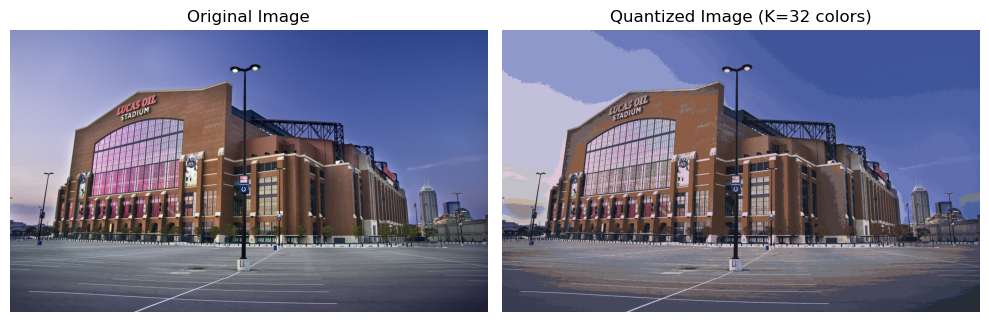

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



# ello - READ THIS 

# make sure cv2 is downloaded. Change file input/output names as well as K values below  
# sometimes it might take a fat minute to load
#------------------------------------------------------------------------------------------------
image_path = "originals/architecture/arc1.jpg"  # CHANGE THIS TO THE CORRECT FILE NAME DO NOT FORGET 
output_path = "compressed_image.jpg"  
K = 32  # MODIFY K  
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image at {image_path}")
#------------------------------------------------------------------------------------------------

# image dimensions
height, width = image.shape[:2]

# turn into 2d array of RBG values
flat_pixels = image.reshape(-1, 3).astype(np.float32)  
num_pixels = flat_pixels.shape[0]  

# choose k 
random_indices = np.random.choice(num_pixels, size=K, replace=False)
representative_colors = flat_pixels[random_indices]  
diff = flat_pixels[:, None, :] - representative_colors[None, :, :]
distances_sq = np.sum(diff**2, axis=2)  

# Distance to nearest color calculations
nearest_color_idx = np.argmin(distances_sq, axis=1)  
quantized_flat_pixels = representative_colors[nearest_color_idx]  
quantized_flat_pixels = np.rint(quantized_flat_pixels).astype(np.uint8)
quantized_image = quantized_flat_pixels.reshape(height, width, 3)

cv2.imwrite(output_path, quantized_image)
print(f"Compressed image saved as {output_path} with {K} colors.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
quantized_image_rgb = cv2.cvtColor(quantized_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')  
plt.subplot(1, 2, 2)
plt.imshow(quantized_image_rgb)
plt.title(f"Quantized Image (K={K} colors)")
plt.axis('off')
plt.tight_layout()
plt.show()

# EDA - Error Metrics Summary (MSE + SSIM)

I created reproducible functions to calculate MSE, SSIM, and generate the table of the metrics summary for each category

In [10]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from skimage.metrics import structural_similarity as ssim 

# --- Metric Calculation Function ---
def calculate_metrics(original_img, compressed_img):
    """
    Calculates MSE and SSIM between the original and compressed images.
    """
    
    # Ensure images have the same shape
    if original_img.shape != compressed_img.shape:
        raise ValueError("Original and compressed images must have the same dimensions.")
        
    # 1. Mean Squared Error (MSE)
    error = np.sum((original_img.astype("float") - compressed_img.astype("float")) ** 2)
    N = float(original_img.shape[0] * original_img.shape[1] * original_img.shape[2])
    mse = error / N
    
    # 2. Structural Similarity Index Measure (SSIM)
    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    compressed_gray = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2GRAY)

    # FIX: Only capture the SSIM score, as your skimage version is not returning the tuple (score, diff_map).
    ssim_score = ssim(original_gray, compressed_gray, data_range=255, channel_axis=None)
    
    return mse, ssim_score

# ---------------------------------------------------------------------------------

In [11]:
def generate_category_matrix(category_name, prefix, k_values, originals_dir="originals", compressed_dir="compressed"):
    """
    Generates the error matrix for a single image category, sorted by image ID and K-Value.
    
    Returns:
        pandas.DataFrame: The resulting error matrix for the category.
    """
    
    original_path = os.path.join(originals_dir, category_name)
    compressed_mod_path = os.path.join(compressed_dir, f"{category_name}_mod")
    
    # Finds files (e.g., 'arc1.jpg', 'arc2.jpg')
    original_files = glob.glob(os.path.join(original_path, f"{prefix}*.jpg"))
    
    if not original_files:
        print(f"Warning: No original files found for category '{category_name}'.")
        return pd.DataFrame()
        
    results = []
    
    print(f"\n--- Processing Category: {category_name.upper()} ---")

    for og_file_path in original_files:
        base_filename = os.path.basename(og_file_path)
        image_id = os.path.splitext(base_filename)[0]
        
        og_image = cv2.imread(og_file_path)
        if og_image is None:
            print(f"Skipping {base_filename}: could not load original image.")
            continue
            
        for K in k_values:
            # Assumes compressed filename: arc1_K4.jpg, arc1_K8.jpg, etc.
            compressed_filename = f"{image_id}_K{K}.jpg" 
            compressed_file_path = os.path.join(compressed_mod_path, compressed_filename)
            
            comp_image = cv2.imread(compressed_file_path)
            
            if comp_image is None:
                print(f"  - Missing compressed file for {image_id} at K={K}. Skipping.")
                continue

            mse, ssim_score = calculate_metrics(og_image, comp_image)
            
            # Store the numeric part of the ID (e.g., 1, 2, 3) for sorting
            image_num_id = int(''.join(filter(str.isdigit, image_id)))
            
            results.append({
                'Image_ID': image_id,
                'Image_Num_ID': image_num_id, # Used for sorting (Requirement 1)
                'K_Value': K,
                'MSE': round(mse, 4),
                'SSIM': round(ssim_score, 4)
            })

    df = pd.DataFrame(results)
    
    # Requirement 1 & 2: Sort by numeric Image ID (ascending) then by K_Value (ascending)
    df = df.sort_values(by=['Image_Num_ID', 'K_Value']).drop(columns=['Image_Num_ID']).reset_index(drop=True)
    
    return df
# ---------------------------------------------------------------------------------

In [12]:
# All K values will be checked
K_VALUES_TO_CHECK = [4, 8, 16] 

CATEGORIES = [
    {'name': 'architecture', 'prefix': 'arc'},
    {'name': 'landscapes', 'prefix': 'land'},
    {'name': 'portraits', 'prefix': 'port'},
    {'name': 'still_life', 'prefix': 'life'},
    {'name': 'urban', 'prefix': 'urb'},
]

# --- Run the generation and collect matrices ---
all_matrices = {}
overall_averages = {}

for cat in CATEGORIES:
    df_matrix = generate_category_matrix(
        category_name=cat['name'],
        prefix=cat['prefix'],
        k_values=K_VALUES_TO_CHECK
    )
    
    if not df_matrix.empty:
        # Calculate the overall average for the category (Requirement 3)
        avg_mse = df_matrix['MSE'].mean()
        avg_ssim = df_matrix['SSIM'].mean()
        overall_averages[cat['name']] = {'Avg_MSE': round(avg_mse, 4), 'Avg_SSIM': round(avg_ssim, 4)}
    
    all_matrices[cat['name']] = df_matrix

# --- Display the results and summaries ---

print("\n\n#####################################################")
print("#### DETAILED ERROR MATRIX SUMMARY BY CATEGORY ####")
print("#####################################################")

# Display the detailed matrices
for category, matrix in all_matrices.items():
    print(f"\n\n--- DETAILED MATRIX: {category.upper()} (K={K_VALUES_TO_CHECK}) ---")
    if not matrix.empty:
        print(matrix.to_markdown(index=False))
    else:
        print("No data available for this category.")

# Display the overall summary (Requirement 3)
print("\n" + "="*53)
print("### CATEGORY OVERALL PERFORMANCE SUMMARY ###")
print("="*53)

# Create a DataFrame for the summary table
summary_df = pd.DataFrame.from_dict(overall_averages, orient='index')
summary_df.index.name = "Category"

# Rename columns for clarity
summary_df.columns = ['Average MSE', 'Average SSIM']

# Display the summary table
print(summary_df.to_markdown())
print("="*53)


--- Processing Category: ARCHITECTURE ---

--- Processing Category: LANDSCAPES ---

--- Processing Category: PORTRAITS ---

--- Processing Category: STILL_LIFE ---

--- Processing Category: URBAN ---


#####################################################
#### DETAILED ERROR MATRIX SUMMARY BY CATEGORY ####
#####################################################


--- DETAILED MATRIX: ARCHITECTURE (K=[4, 8, 16]) ---
| Image_ID   |   K_Value |       MSE |   SSIM |
|:-----------|----------:|----------:|-------:|
| arc1       |         4 |  446.841  | 0.8022 |
| arc1       |         8 |  191.564  | 0.8498 |
| arc1       |        16 |  195.554  | 0.8889 |
| arc2       |         4 |  555.808  | 0.8346 |
| arc2       |         8 |  143.579  | 0.8702 |
| arc2       |        16 |  346.135  | 0.8348 |
| arc3       |         4 | 1018.65   | 0.7189 |
| arc3       |         8 |  427.428  | 0.7627 |
| arc3       |        16 |  431.874  | 0.7416 |
| arc4       |         4 |  413.322  | 0.8439 |
| arc4

Explanation: 
Error Metrics Summary (MSE & SSIM)
To evaluate how well our compressed images perform at different k-values, we summarize two key metrics for every category: MSE and SSIM. MSE, or mean squared error, measures the average squared difference between the original and compressed images, so lower values mean the compressed image stays closer to the original. SSIM, or structural similarity index, compares the structure, brightness, and contrast of the two images. It ranges from 0 to 1, with values closer to 1 indicating higher similarity. Using both metrics gives a balanced understanding of pixel-level accuracy and perceptual quality.

From the category tables, we can see how each individual image behaves across different k-values. Some images show only small changes in MSE and SSIM when k increases, meaning they are easier to compress and maintain quality even at lower k. Others show large drops in SSIM or spikes in MSE at low k, meaning they require more clusters to preserve their structure or color variations. By reading across each row, we can identify consistent patterns, such as which images lose detail quickly, which ones stay stable across k, and how sensitivity differs based on image content.

At the end, the overall summary table averages MSE and SSIM at each k for the entire category. This tells us the general performance of each category instead of focusing on individual images. From this, we can see which categories compress well as a whole, which k-values give the best balance between compression and quality, and how categories differ in structural or pixel-level loss. These averages help guide a broader conclusion about the optimal k-value and which types of images are more or less compressible overall.

# Optimization: EDA of K-means Clustering on Architecture

In [19]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from skimage.metrics import structural_similarity as ssim

# ---------- Metrics ----------
def calculate_metrics(original_img, compressed_img):
    # MSE
    error = np.sum((original_img.astype("float") - compressed_img.astype("float")) ** 2)
    N = float(original_img.shape[0] * original_img.shape[1] * original_img.shape[2])
    mse = error / N

    # SSIM (convert to grayscale)
    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    compressed_gray = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2GRAY)
    ssim_score = ssim(original_gray, compressed_gray, data_range=255, channel_axis=None)

    return mse, ssim_score


def generate_opt_matrix(category_name, prefix, originals_dir, compressed_dir):
    """
    Compare originals vs *opt images for one category.
    Example:
        originals/architecture/arc1.jpg
        compressed/architecture_opt/arc1opt.jpg
    """
    original_path = os.path.join(originals_dir, category_name)
    compressed_opt_path = os.path.join(compressed_dir, f"{category_name}_opt")

    original_files = glob.glob(os.path.join(original_path, f"{prefix}*.jpg"))
    if not original_files:
        print(f"Warning: no originals for {category_name}")
        return pd.DataFrame()

    rows = []

    for og_file_path in original_files:
        base = os.path.basename(og_file_path)       # arc1.jpg
        image_id = os.path.splitext(base)[0]        # arc1

        og = cv2.imread(og_file_path)
        if og is None:
            print(f"Skipping {base}: cannot load original.")
            continue

        comp_name = f"{image_id}opt.jpg"            # arc1opt.jpg
        comp_path = os.path.join(compressed_opt_path, comp_name)
        comp = cv2.imread(comp_path)

        if comp is None:
            print(f"Missing optimized file: {comp_name}")
            continue

        mse, ssim_score = calculate_metrics(og, comp)

        num_part = ''.join(filter(str.isdigit, image_id))
        num_id = int(num_part) if num_part else 0

        rows.append({
            "Image_ID": image_id + "opt",
            "Image_Num_ID": num_id,
            "MSE": round(mse, 4),
            "SSIM": round(ssim_score, 4)
        })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df = df.sort_values("Image_Num_ID").drop(columns=["Image_Num_ID"]).reset_index(drop=True)
    return df


# ----- RUN: K-means on ARCHITECTURE -----
originals_dir = r"originals"
compressed_dir = r"compressed"

arch_df = generate_opt_matrix(
    category_name="architecture",
    prefix="arc",
    originals_dir=originals_dir,
    compressed_dir=compressed_dir
)

print("--- OPTIMIZED MATRIX: ARCHITECTURE (K-means) ---")
print(arch_df.to_markdown(index=False))

print("\n--- ARCHITECTURE (K-means) AVERAGES ---")
print(f"Average MSE  : {arch_df['MSE'].mean():.4f}")
print(f"Average SSIM : {arch_df['SSIM'].mean():.4f}")


--- OPTIMIZED MATRIX: ARCHITECTURE (K-means) ---
| Image_ID   |       MSE |   SSIM |
|:-----------|----------:|-------:|
| arc1opt    |   49.2148 | 0.9283 |
| arc2opt    |   30.8436 | 0.944  |
| arc3opt    |  144.153  | 0.8475 |
| arc4opt    |   36.8806 | 0.9514 |
| arc5opt    |   43.5786 | 0.949  |
| arc6opt    | 7216.81   | 0.8634 |
| arc7opt    |   34.1229 | 0.9479 |
| arc8opt    |   19.4338 | 0.9474 |
| arc9opt    |   26.5575 | 0.9424 |
| arc10opt   |   25.8229 | 0.9427 |
| arc11opt   |   55.6654 | 0.8691 |
| arc12opt   |   24.4445 | 0.9538 |
| arc13opt   |   29.7676 | 0.9126 |
| arc14opt   |   17.2027 | 0.968  |
| arc15opt   |   10.1125 | 0.9731 |
| arc16opt   |   50.811  | 0.9475 |
| arc17opt   |   60.6909 | 0.9139 |
| arc18opt   |   16.5576 | 0.9535 |
| arc19opt   |   56.7487 | 0.9217 |
| arc20opt   |   32.2402 | 0.9207 |
| arc21opt   |    8.4035 | 0.98   |
| arc22opt   |   46.2274 | 0.8992 |
| arc23opt   |   70.5238 | 0.9034 |

--- ARCHITECTURE (K-means) AVERAGES ---
Average MS

# Technique 2: KNN (Supervised Learning)

# EDA of KNN for Landscapes

In [20]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from skimage.metrics import structural_similarity as ssim

# ---------- Metrics ----------
def calculate_metrics(original_img, compressed_img):
    # MSE
    error = np.sum((original_img.astype("float") - compressed_img.astype("float")) ** 2)
    N = float(original_img.shape[0] * original_img.shape[1] * original_img.shape[2])
    mse = error / N

    # SSIM (convert to grayscale)
    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    compressed_gray = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2GRAY)
    ssim_score = ssim(original_gray, compressed_gray, data_range=255, channel_axis=None)

    return mse, ssim_score


def generate_opt_matrix(category_name, prefix, originals_dir, compressed_dir):
    """
    Compare originals vs *opt images for one category.
    Example:
        originals/landscapes/land1.jpg
        compressed/landscapes_opt/land1opt.jpg
    """
    original_path = os.path.join(originals_dir, category_name)
    compressed_opt_path = os.path.join(compressed_dir, f"{category_name}_opt")

    original_files = glob.glob(os.path.join(original_path, f"{prefix}*.jpg"))
    if not original_files:
        print(f"Warning: no originals for {category_name}")
        return pd.DataFrame()

    rows = []

    for og_file_path in original_files:
        base = os.path.basename(og_file_path)       # land1.jpg
        image_id = os.path.splitext(base)[0]        # land1

        og = cv2.imread(og_file_path)
        if og is None:
            print(f"Skipping {base}: cannot load original.")
            continue

        comp_name = f"{image_id}opt.jpg"            # land1opt.jpg
        comp_path = os.path.join(compressed_opt_path, comp_name)
        comp = cv2.imread(comp_path)

        if comp is None:
            print(f"Missing optimized file: {comp_name}")
            continue

        mse, ssim_score = calculate_metrics(og, comp)

        num_part = ''.join(filter(str.isdigit, image_id))
        num_id = int(num_part) if num_part else 0

        rows.append({
            "Image_ID": image_id + "opt",
            "Image_Num_ID": num_id,
            "MSE": round(mse, 4),
            "SSIM": round(ssim_score, 4)
        })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df = df.sort_values("Image_Num_ID").drop(columns=["Image_Num_ID"]).reset_index(drop=True)
    return df


# ----- RUN: KNN on LANDSCAPES -----
originals_dir = r"originals"
compressed_dir = r"compressed"

land_df = generate_opt_matrix(
    category_name="landscapes",
    prefix="land",
    originals_dir=originals_dir,
    compressed_dir=compressed_dir
)

print("--- OPTIMIZED MATRIX: LANDSCAPES (KNN) ---")
print(land_df.to_markdown(index=False))

print("\n--- LANDSCAPES (KNN) AVERAGES ---")
print(f"Average MSE  : {land_df['MSE'].mean():.4f}")
print(f"Average SSIM : {land_df['SSIM'].mean():.4f}")


--- OPTIMIZED MATRIX: LANDSCAPES (KNN) ---
| Image_ID   |      MSE |   SSIM |
|:-----------|---------:|-------:|
| land1opt   |  60.5248 | 0.9521 |
| land2opt   |  65.0525 | 0.9598 |
| land3opt   |  78.3523 | 0.9104 |
| land4opt   |  53.1993 | 0.9733 |
| land5opt   |  93.3887 | 0.9217 |
| land6opt   |  73.6987 | 0.9656 |
| land7opt   |  59.6828 | 0.9444 |
| land8opt   |  97.7992 | 0.9581 |
| land9opt   |  71.4247 | 0.9419 |
| land10opt  |  59.6316 | 0.9582 |
| land11opt  |  66.2949 | 0.9594 |
| land12opt  |  48.1743 | 0.9804 |
| land13opt  |  28.6206 | 0.9662 |
| land14opt  |  79.9504 | 0.9325 |
| land15opt  |  77.6933 | 0.9296 |
| land16opt  |  71.9145 | 0.9408 |
| land17opt  | 129.935  | 0.9512 |
| land18opt  |  48.4453 | 0.9675 |
| land19opt  |  80.8786 | 0.9578 |
| land20opt  | 235.049  | 0.8934 |
| land21opt  |  57.6697 | 0.9378 |
| land22opt  |  58.8201 | 0.9659 |
| land23opt  |  67.1414 | 0.9778 |

--- LANDSCAPES (KNN) AVERAGES ---
Average MSE  : 76.6670
Average SSIM : 0.9498


# Analysis

As evident by the compressed images, the colors are approximated using K-Means method and then stored into clusters based on their similarity. From this, an approximation of the colors is formed and applied to all the pixels that fall within that particular cluster. This means that the larger the defined K value is, the closer the produced image will be to the original image. 

In terms of the error, portraits have the lowest average MSE at 276.53 and a low overall SSIM of 0.7857. This indicates an overall low compression quality for this category of image. While the numerical change between a pixel's color value is low (MSE), the low SSIM means that the structural information of the entire image is poor. A possible explanation for these values would be the smoothness of the subjects' skin, subtle lighting with tonal gradients, and blurred backgrounds. All of these factors contribute to making a complex image that is difficult for the colors to be approximated and put into clusters.

On the other hand, Still Life images have the highest average SSIM at 0.8464, and an average MSE of 305.19. This indicates that it has the best preservation of quality after the compression algorithm is run. An explanation for this high performance is from the nature of Still Life images as a whole, where objects are well defined and have relatively smooth surfaces, making color clustering an effective method to use for compression.

Applying the optimized K-means algorithm and K nearest neighbors to architecture and landscapes drastically improved the image quality. Average MSE for architecture and landscapes were 352.4702 and 76.6670 respectably. From the results, it appears that applying KNN brought upon it the best image compressed in terms of MSE and SSIM scores, however it took 2-3 minutes to process each image. The impact of optimizing the K-means algorithm by running it at K = 32 also increased the processing times to 2-3 minutes aswell. Overall, both algorithms are effective, however running these algorithms for the rest of our findings would be computationally expensive and time consuming.

# Conclusion

Going back to our hypothesis and cross referencing it to our matrix of results for each category, we can conclude that compression performance is indeed worse for images with higher edge density and color diversity when the k value is low. Architecture and Urban images exhibit high average MSE at k=4 (452 and 453 respectively), and low SSIM (0.796 and 0.729 respectively). This combination indicates a low compression performance due to there being an insufficient amount of clusters to accomodate the high variety of colors, ultimately resulting in a major loss in quality after compression is applied. Thus, the hypothesis is reinforced.

# Team Contribution

Ryan Kim
*   Image dataset collection and category contribution.
*   File compression testing and exporting for various k values across all categories.
*   Video report editing and documentation.

Stuart Arief:
*   Analysis and Conclusion 

Lydia Niu
* EDA of the error metrics summary of MSE and SSIM
* Final report compilation

Jonathan Chun - 
* Optimized architecture through K-means 
* Optimized landscape through KNN
Colin Pham - 